Load libraries

In [2]:
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np
from google.colab.patches import cv2_imshow
import imutils
import hashlib
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC, Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')

print("GPU:", tf.config.list_physical_devices('GPU'))
print("Num GPUs:", len(physical_devices))

GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs: 1


# Load Data

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [5]:
def load_data(root, types, labels, image_size=200):
    """
    Loads images and their corresponding labels from the preprocessed dataset.

    Args:
        root (str): Root directory containing the preprocessed images.
        types (list): Data types (e.g., ['Training', 'Testing']).
        labels (list): List of class labels corresponding to subfolders.
        image_size (int): Size of the images (assumes square dimensions).

    Returns:
        X (list): List of flattened images.
        y (list): Corresponding labels.
    """
    X, y = [], []
    for t in types:
        for label in labels:
            path = os.path.join(root, t, label)
            if not os.path.exists(path):
                continue
            for file in os.listdir(path):
                img_path = os.path.join(path, file)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is None:
                    print(f"Warning: {img_path} could not be loaded.")
                    continue
                img = cv2.resize(img, (image_size, image_size))  # Ensure consistent size
                X.append(img.flatten())  # Flatten the image into a 1D array
                y.append(labels.index(label))
    return np.array(X), np.array(y)

In [6]:
root = '/content/drive/MyDrive/TFM/cropped_images'
types = ['Training', 'Testing']
labels = ['glioma', 'meningioma', 'pituitary', 'notumor']
image_size = 200

In [7]:
# Load the data
X_train, y_train = load_data(root, [types[0]], labels, image_size)
X_test, y_test = load_data(root, [types[1]], labels, image_size)

In [8]:
#Normalize images to [0,1]
X_train = np.array(X_train) / 255.0
X_test = np.array(X_test) / 255.0

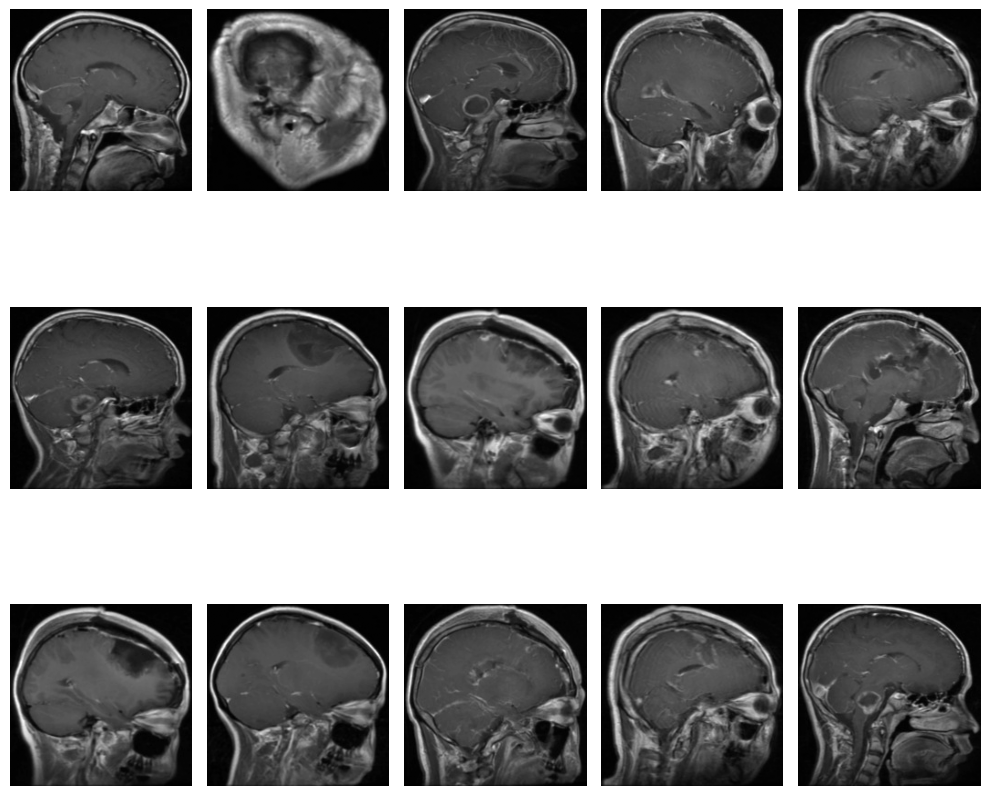

In [9]:
# Reshape and display flattened images
images = [X_train[i].reshape(image_size, image_size) for i in range(15)]  # Reshape each image to its original size
fig, axes = plt.subplots(3, 5, figsize=(10, 10))
axes = axes.flatten()
for img, ax in zip(images, axes):
    ax.imshow(img, cmap='gray')  # Display the reshaped image
    ax.axis('off')  # Turn off axis labels
plt.tight_layout()
plt.show()

# Training of the Custom NN

In [10]:
# Parameters
image_size = 200
num_classes = 4  # Number of categories (glioma, meningioma, pituitary, notumor)
batch_size = 32
epochs = 20

In [11]:
# Reshape the data for the CNN (with the channel dimension)
X_train = X_train.reshape(-1, image_size, image_size, 1)
X_test = X_test.reshape(-1, image_size, image_size, 1)

In [12]:
print(X_train.shape)
print(X_test.shape)

(5712, 200, 200, 1)
(1311, 200, 200, 1)


In [13]:
# Convert labels to categorical
y_train = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)

In [14]:
num_classes

4

In [15]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(X_train)

In [23]:
# @title
model = Sequential([
    # First convolutional block
    Conv2D(32, (3, 3), activation='relu', input_shape=(image_size, image_size, 1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    # Second convolutional block
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    # Third convolutional block
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.4),

    # Flatten the feature maps into a single vector
    Flatten(),

    # Fully connected layers
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')  # Output layer with softmax for multi-class classification
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [24]:
# @title
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=[
                  'accuracy',                    # Overall accuracy
                  Precision(name='precision'),   # Precision to track false positives
                  Recall(name='recall'),         # Recall (sensitivity) to track false negatives
                  AUC(name='auc')                # AUC-ROC metric
              ]
)

In [25]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 198, 198, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 198, 198, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 99, 99, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 99, 99, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 97, 97, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 97, 97, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 48, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 48, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 46, 46, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 46, 46, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 23, 23, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 23, 23, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 67712)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       8,667,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,761,348 (33.42 MB)

 Trainable params: 8,760,900 (33.42 MB)

 Non-trainable params: 448 (1.75 KB)

Total Parameters: 8761348


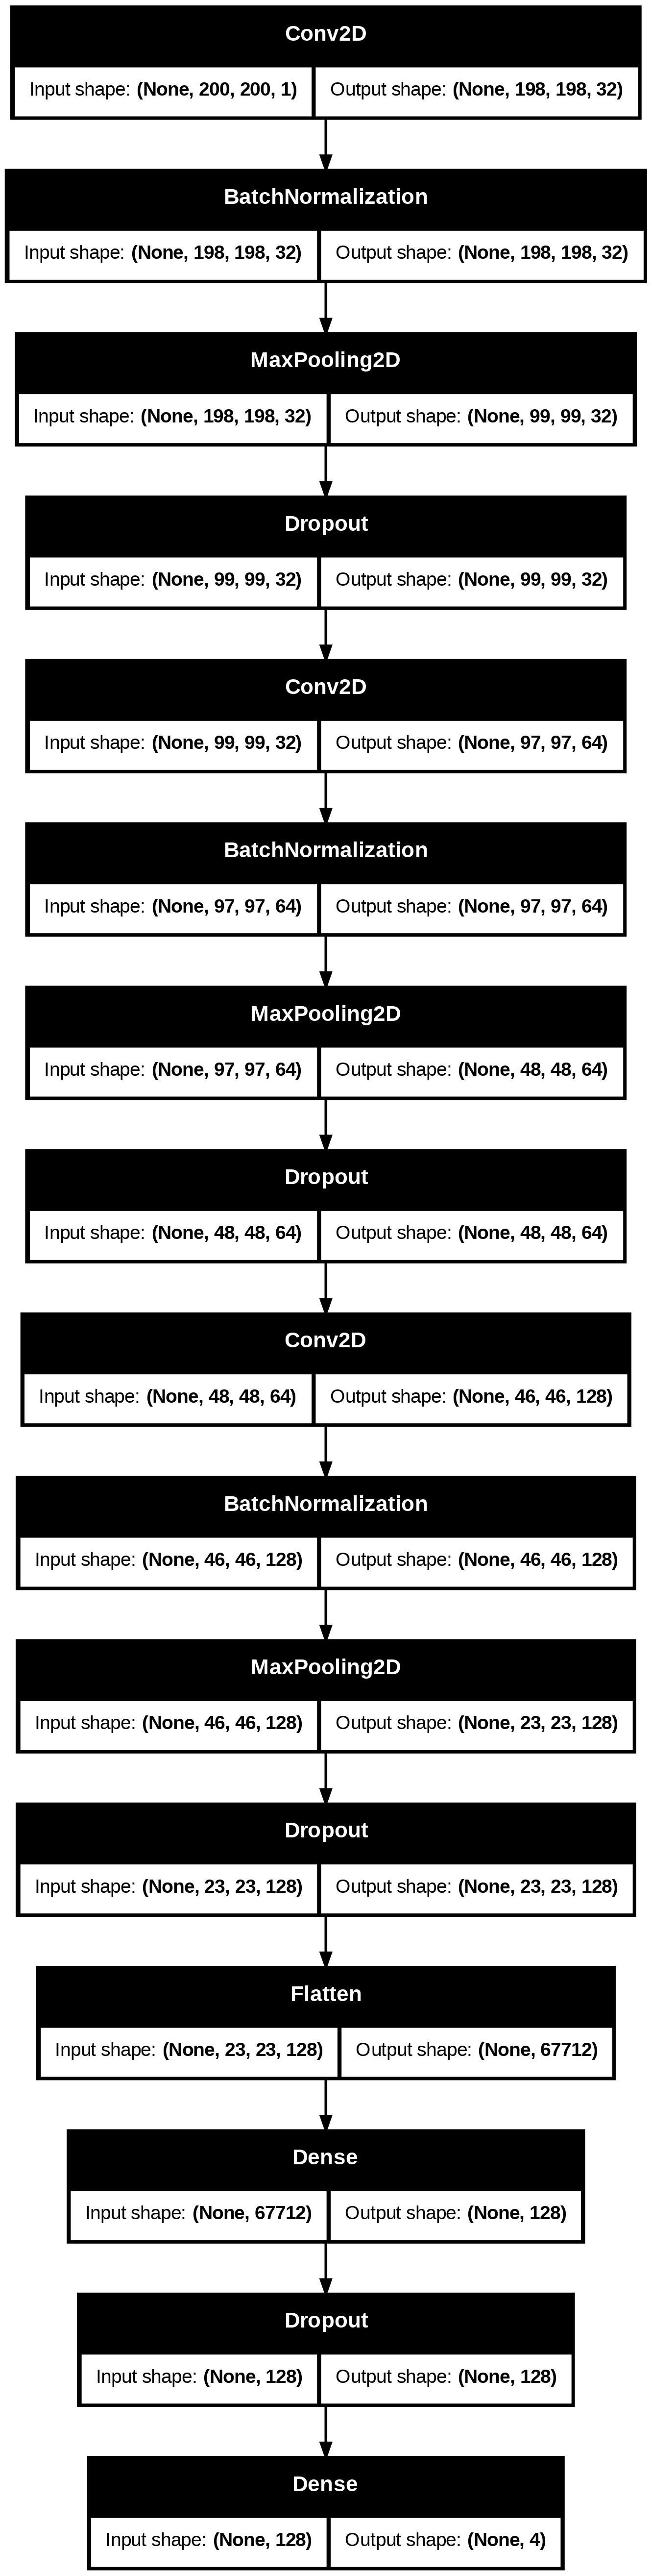

In [26]:
from tensorflow.keras.utils import plot_model

# Total number of parameters
total_params = model.count_params()
print(f"Total Parameters: {total_params}")

# Visualize the model (optional)
plot_model(model, show_shapes=True, to_file='model_structure.png')


In [27]:
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=epochs,
    batch_size=batch_size,
    verbose = 1
)

Epoch 1/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 36s 148ms/step - accuracy: 0.4492 - auc: 0.6893 - loss: 7.0195 - precision: 0.5232 - recall: 0.3335 - val_accuracy: 0.2607 - val_auc: 0.5462 - val_loss: 8.0718 - val_precision: 0.2607 - val_recall: 0.2607
Epoch 2/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 17s 47ms/step - accuracy: 0.5260 - auc: 0.8023 - loss: 1.1365 - precision: 0.7543 - recall: 0.3179 - val_accuracy: 0.3640 - val_auc: 0.6722 - val_loss: 4.4181 - val_precision: 0.3640 - val_recall: 0.3640
Epoch 3/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - accuracy: 0.5322 - auc: 0.8159 - loss: 1.0507 - precision: 0.7790 - recall: 0.3450 - val_accuracy: 0.3832 - val_auc: 0.6242 - val_loss: 6.4584 - val_precision: 0.3880 - val_recall: 0.3806
Epoch 4/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - accuracy: 0.5800 - auc: 0.8502 - loss: 0.9355 - precision: 0.8177 - recall: 0.3817 - val_accuracy: 0.3088 - val_auc: 0.6202 - val_loss: 2.5124 - val_precision: 0.4173 - val_recall: 0.2782
Epoch 5/20
143/143 ━━━━━

In [28]:
# Evaluate the model
model.evaluate(X_test, y_test)

41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 0.6604 - auc: 0.8258 - loss: 2.1919 - precision: 0.6935 - recall: 0.5806


[1.1821107864379883,
 0.7376048564910889,
 0.7786324620246887,
 0.6948894262313843,
 0.909355878829956]

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Complex CNN with more parameters
model = Sequential([
    # First convolutional block
    Conv2D(64, (3, 3), activation='relu', input_shape=(image_size, image_size, 1)),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    # Second convolutional block
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.4),

    # Third convolutional block
    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.5),

    # Fourth convolutional block
    Conv2D(512, (3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(512, (3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(512, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.5),

    # Flatten the feature maps
    Flatten(),

    # Fully connected layers
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')  # Output layer
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=[
                  'accuracy',                    # Overall accuracy
                  Precision(name='precision'),   # Precision to track false positives
                  Recall(name='recall'),         # Recall (sensitivity) to track false negatives
                  AUC(name='auc')                # AUC-ROC metric
              ]
)

# Summary of the model
model.summary()



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)                   │ (None, 198, 198, 64)        │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 198, 198, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 196, 196, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 196, 196, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 98, 98, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 98, 98, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 96, 96, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 96, 96, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 94, 94, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 94, 94, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 47, 47, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 47, 47, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 45, 45, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 45, 45, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 43, 43, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 43, 43, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 41, 41, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 41, 41, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │              

 Total params: 33,862,852 (129.18 MB)

 Trainable params: 33,857,476 (129.16 MB)

 Non-trainable params: 5,376 (21.00 KB)

In [18]:
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=epochs,
    batch_size=batch_size,
    verbose = 1
)

Epoch 1/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 162s 817ms/step - accuracy: 0.4104 - auc: 0.6414 - loss: 10.8548 - precision: 0.4115 - recall: 0.4057 - val_accuracy: 0.8679 - val_auc: 0.9854 - val_loss: 0.3045 - val_precision: 0.8679 - val_recall: 0.8679
Epoch 2/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 97s 339ms/step - accuracy: 0.5178 - auc: 0.7611 - loss: 2.8795 - precision: 0.5444 - recall: 0.4627 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 0.4272 - val_precision: 1.0000 - val_recall: 0.9991
Epoch 3/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 80s 323ms/step - accuracy: 0.6081 - auc: 0.8349 - loss: 1.1965 - precision: 0.6569 - recall: 0.5305 - val_accuracy: 0.7900 - val_auc: 0.9492 - val_loss: 0.7571 - val_precision: 0.9372 - val_recall: 0.5092
Epoch 4/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 48s 338ms/step - accuracy: 0.6807 - auc: 0.8855 - loss: 0.9599 - precision: 0.7290 - recall: 0.5974 - val_accuracy: 0.2800 - val_auc: 0.7235 - val_loss: 1.1439 - val_precision: 0.3927 - val_recall: 0.1872
Epoch 5/20
143/143

In [19]:
model.evaluate(X_test, y_test)

41/41 ━━━━━━━━━━━━━━━━━━━━ 15s 375ms/step - accuracy: 0.8797 - auc: 0.9704 - loss: 0.4098 - precision: 0.9098 - recall: 0.8383


[0.2949860394001007,
 0.9031273722648621,
 0.9334415793418884,
 0.8771929740905762,
 0.9842298626899719]

In [20]:
model.save('NN_custom.h5')  # Save the model in HDF5 format

In [51]:
from tensorflow.keras.models import load_model

# Load the HDF5 model
model = load_model('/content/drive/MyDrive/TFM/NN_custom.h5')

In [52]:
# Predict on the test set
y_pred_probs = model.predict(X_test)  # Predicted probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class indices

# True class labels
y_true = np.argmax(y_test, axis=1)  # If y_test is one-hot encoded

41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step


In [53]:
from sklearn.metrics import confusion_matrix

# Create the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[253  34  10   3]
 [  7 285  10   4]
 [  0  10 290   0]
 [  6  43   0 356]]
